In [1]:
import scanpy as sc
import numpy as np
import sctm
import squidpy as sq
import pandas as pd
import scvi

%load_ext autoreload
%autoreload 2

/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmp6g8dz7lf
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmp6g8dz7lf/_remote_module_non_scriptable.py
/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_trai

In this tutorial, we demonstrate how to analyse single cell level nanostring smi data. We used replicate 12 to demonstrate here instead of 5-3 in our paper. We transferred our data from the Giotto object located here https://nanostring.com/products/cosmx-spatial-molecular-imager/nsclc-ffpe-dataset

In [2]:
adata = sc.read_h5ad("../../../../spatialLDA/spatiallda/reproducibility/figure2/data/Lung12.h5ad")
adata.var_names_make_unique()

In [3]:
adata.obsm['spatial'] = adata.obsm['spatial_raw']

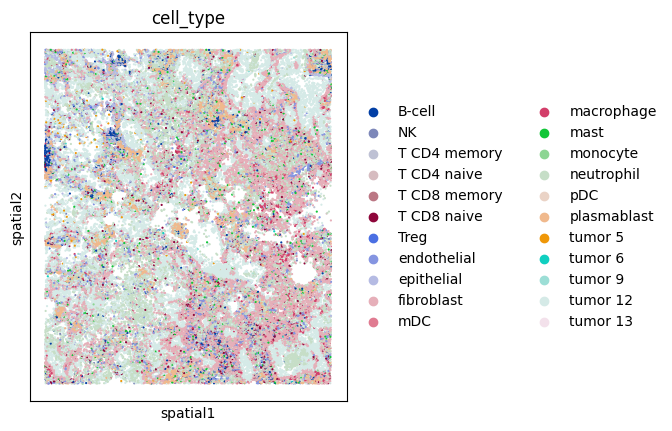

In [4]:
sc.pl.spatial(adata, spot_size = 0.03, color = 'cell_type')

In [5]:
sc.pp.filter_cells(adata, min_genes=30)
sctm.pp.filter_genes(adata, 0.01,  expression_cutoff_99q = 0)
sc.pp.highly_variable_genes(adata, n_top_genes=600, flavor="seurat_v3")

In [6]:
sq.gr.spatial_neighbors(adata)

In [7]:
n_topics = 15
# 
model = sctm.stamp.STAMP(
    adata[:, adata.var.highly_variable],
    n_topics = n_topics,
)

# uses gpu by default to use cpu use device="cpu"
model.train(learning_rate = 0.01)

Computing background frequencies


/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/torch_geometric/utils/sparse.py:216: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:54.)
  return adj.to_sparse_csc()
Loss:257.347:  10%|█         | 102/1000 [10:58<1:36:35,  6.45s/it]

Early Stopping


In [8]:
# Get topic prop which is the latent representation and beta which are the gene modules
topic_prop = model.get_cell_by_topic()
beta = model.get_feature_by_topic()
# Add it into adata to visualize
for i in topic_prop.columns:
    adata.obs[i] = topic_prop[i]

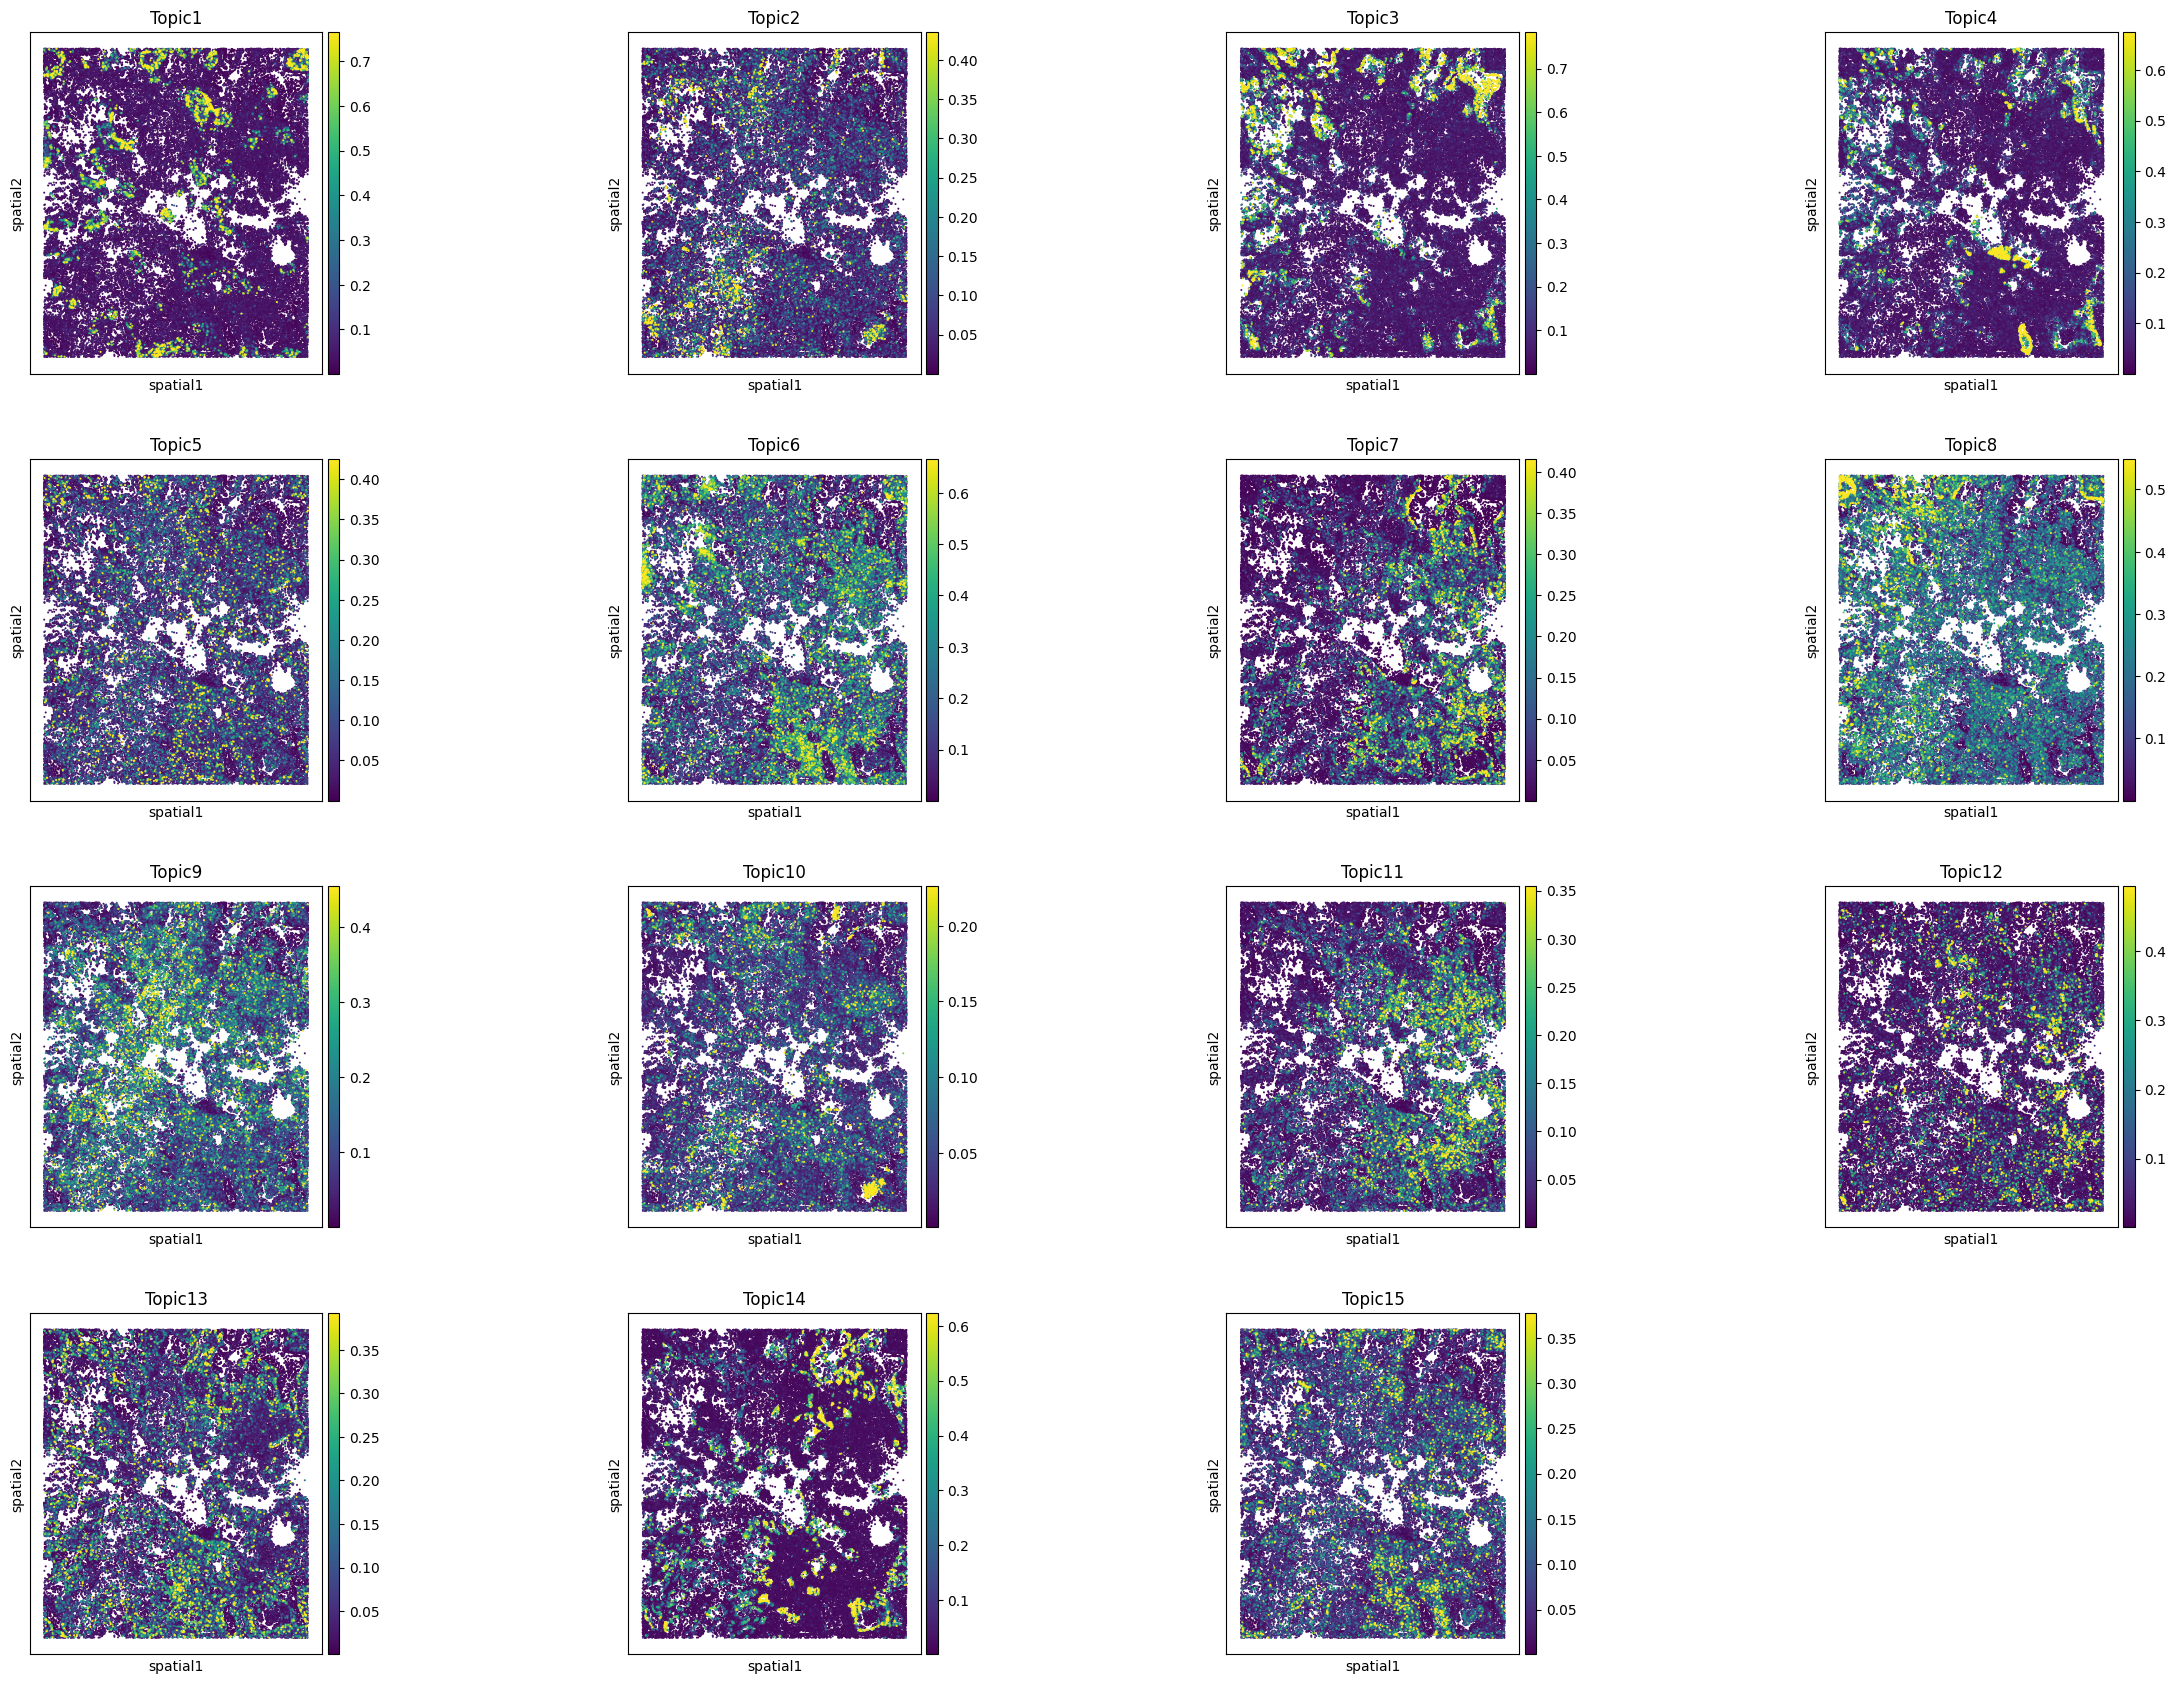

In [9]:
sc.pl.spatial(adata, color = topic_prop.columns, spot_size = 0.03, vmax = 'p99')

Here we used the disco function which calls discotoolkit_py to do enrichment analysis.

The website for DISCO can be found here https://immunesinglecell.org/, where over 60 million cells are processed and built into atlases.

In [10]:
celltypes = sctm.analysis.get_topic_disco(beta)

INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend Sequentia

In [15]:
filtered = [] 
for i in celltypes.keys():
    # Filter out the low overlap
    df = celltypes[i].loc[celltypes[i].overlap > 5]
    # Filter only in lung
    df = df.loc[df['name'].str.contains("lung")]
    df["Topic"] = i
    filtered.append(df.head(2))

In [16]:
filtered = pd.concat(filtered)
filtered

pval       or                                               name   
253   0.0  100.841                  Plasma cell vs All others in lung  \
248   0.0   31.311               Plasma cell vs Memory B cell in lung   
332   0.0   54.960                         cDC2 vs All others in lung   
315   0.0   50.058             CD14 monocyte vs CD16 monocyte in lung   
613   0.0   52.504                   Goblet cell vs Club cell in lung   
636   0.0   32.367                  Goblet cell vs All others in lung   
428   0.0   32.574           Goblet cell vs Airway basal cell in lung   
451   0.0   30.316                  Goblet cell vs All others in lung   
135   0.0   28.878                  Capillary EC vs Venous EC in lung   
134   0.0   22.627                Capillary EC vs Arterial EC in lung   
283   0.0   70.797  ADAMDEC1+ADAM28+ fibroblast vs All others in lung   
287   0.0   58.363                Myofibroblast vs All others in lung   
318   0.0   50.140           Goblet cell vs Airway basal cell in lung   
332   0.0   37.761                  Goblet cell vs All others in lung   
280   0.0   43.131                Myofibroblast vs All others in lung   
276   0.0   40.784  ADAMDEC1+ADAM28+ fibroblast vs All others in lung   
449   0.0  225.370                M1 macrophage vs All others in lung   
452   0.0  158.444      G2/M phase myeloid cell vs All others in lung   
398   0.0   52.386  Vascular smooth muscle cell vs All others in lung   
313   0.0   23.773            Airway basal cell vs All others in lung   
490   0.0   81.827              GZMK CD8 T cell vs All others in lung   

                                                  gene background overlap   
253  IGKC,CD38,JCHAIN,MZB1,PNOC,IGHG2,IGHA1,IGHG1,I...       9264      12  \
248  MZB1,JCHAIN,IGHM,IGHA1,TNFRSF17,IGHG1,CD38,RGS...       9264      11   
332  IL1R2,CLEC7A,NLRP3,OLR1,IL1B,HCK,CSF3R,CCL3,CX...       9264      12   
315          S100A8,IL1R2,CXCL8,CSF3R,IL1RN,OLR1,NLRP3       9264       7   
613  S100A6,CEACAM6,PSCA,S100P,PLAC8,LGALS3,EPHA2,G...       9264      11   
636          S100P,AGR2,CLDN4,PSCA,KRT19,CEACAM6,EPHA2       9264       7   
428                   PIGR,LCN2,LYZ,SERPINA1,MMP7,AGR2       9264       6   
451                     PIGR,AGR2,LCN2,MMP7,KRT8,GSTP1       9264       6   
135      ESAM,IL1RL1,RAMP2,EFNB2,PDGFB,KIT,CDH5,ADGRL2       9264       8   
134        RAMP3,ADGRL2,IL1RL1,KIT,ESAM,PDGFB,KDR,RGS5       9264       8   
283  COL3A1,COL6A3,PDGFRA,COL1A2,CDH11,COL1A1,COL6A...       9264      15   
287  ACTG2,COL3A1,COL1A2,ACTA2,TPM1,COL1A1,MYL9,COL...       9264      14   
318       SCGB3A1,SLPI,CXCL17,CLU,LTF,CXCL2,MMP7,CXCL3       9264       8   
332           LTF,CXCL1,SCGB3A1,MMP7,SLPI,CXCL17,CXCL2       9264       7   
280  ACTG2,CXCL14,ACTA2,TPM1,MYH11,COL1A1,MEG3,WNT5...       9264      12   
276  PDGFRA,CXCL14,CDH11,COL1A1,CXCL12,MEG3,ACTA2,A...       9264      12   
449  C1QA,C1QC,C1QB,FCER1G,GLUL,MARCO,CD14,CD74,HLA...       9264      18   
452  C1QA,C1QC,C1QB,FCER1G,MARCO,GPNMB,MS4A4A,CD68,...       9264      18   
398  IGFBP5,SPARCL1,GPX3,ACTA2,MGP,MYH11,COL6A2,MT2...       9264      15   
313  SLC2A1,TACSTD2,S100A2,CDH1,KRT19,KRT17,KRT7,CC...       9264       9   
490  CD2,CD8A,DUSP2,CXCR4,FYB1,GZMK,GZMA,CD3D,CD69,...       9264      17   

    geneset    Topic  
253     157   Topic1  
248     387   Topic1  
332     361   Topic2  
315     138   Topic2  
613     216   Topic3  
636     166   Topic3  
428     155   Topic4  
451     166   Topic4  
135     223   Topic5  
134     281   Topic5  
283     413   Topic7  
287     392   Topic7  
318     155   Topic8  
332     166   Topic8  
280     392  Topic11  
276     413  Topic11  
449     390  Topic12  
452     539  Topic12  
398     461  Topic13  
313     348  Topic14  
490     497  Topic15

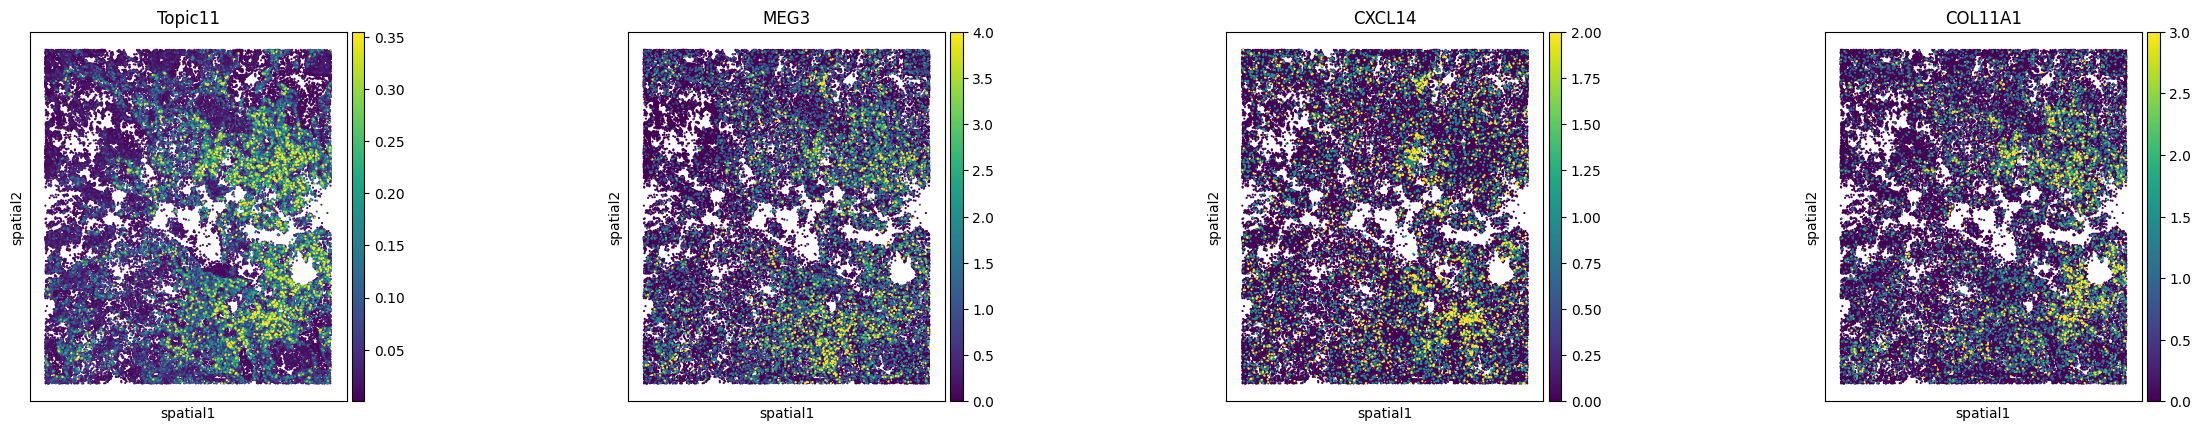

In [17]:
# Plot out myofibrolast and top genes "Topic11"
sc.pl.spatial(adata, color = ["Topic11"] + beta.nlargest(3, "Topic11").index.tolist(), spot_size = 0.03, vmax ='p99')